In [1]:
import sys
sys.path.append('..')
import jax
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
from src.util import *
from src.plot import *
from src.stokes import *

In [2]:
import time
N = 802
eta = 0.5
t, w = trapez(N)

@jit
def lu_solve_geometry(c, t, w, eta):
    g = lambda t: from_complex(fourier_eval_flat(t, c))
    mat = stackmatrix(mlp_matrix(g, t, w, eta))
    lu_sol = lu_factor(mat)
    return lu_sol

def force_at_angle(theta, c, t, w, lu_sol):
    g = lambda t: from_complex(fourier_eval_flat(t, c))
    uinf = from_complex(jnp.exp(1j*theta))
    rhs = stackvector(constant_vector_field(-uinf, t))
    q = unstackvector(lu_solve(lu_sol, rhs))
    return -force(q, g, t, w)

vmapped_force = jit(lambda t1, c, t2, w, lu_sol: \
                vmap(force_at_angle, (0, None, None, None, None))(t1, c, t2, w, lu_sol))

c = jnp.load("../data/data_0.npy")[0]

t_start = time.time()
Mi = 23
N_eval = 100
t_eval = jnp.linspace(0, 2*jnp.pi, N_eval+1)[:-1]

for j in range(Mi):
    c_data = jnp.load(f'../data/data_{j}.npy')
    M = c_data.shape[0]
    f_data = jnp.zeros((M, N_eval, 2))
    for i in range(M):
        # Compute
        c = c_data[i]
        lu_sol = lu_solve_geometry(c, t, w, eta)
        forces = vmapped_force(t_eval, c, t, w, lu_sol)
        f_data = f_data.at[i].set(forces)
        
        # Info
        t_elapsed = time.time() - t_start
        t_total = t_elapsed * (M*Mi)/(j*M+i+1)
        t_remaining = t_total - t_elapsed
        print(f"step {i}/{M}, block {j}/{Mi}, elapsed: {int(t_elapsed//60):d} min, " + \
            f"remaining: {int(t_remaining//60):d} min. Total: {int(t_total//60):d} min          ", end="\r")
    
    jnp.save(f"../data/f_data_{j}.npy", f_data)



KeyboardInterrupt: 

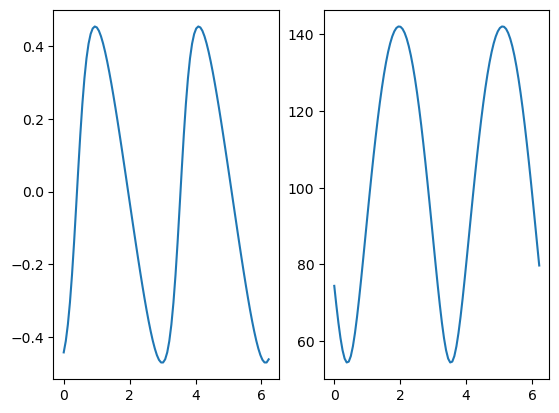

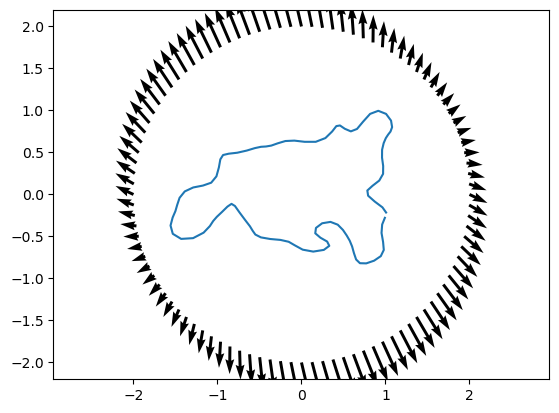

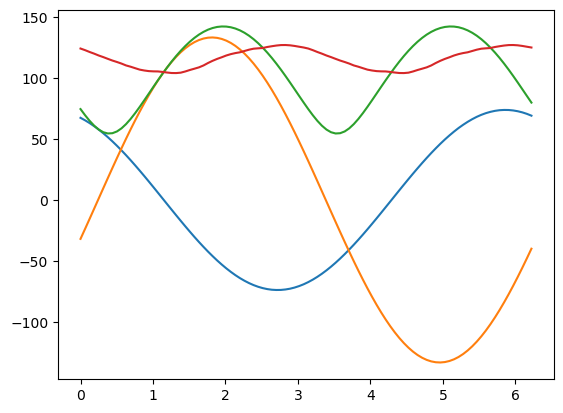

In [22]:
def physical(t, f):
    xy = vmap(lambda t: from_complex(jnp.exp(1j*t)))(t)
    dot = lambda x, y: jnp.sum(x*y)
    return jnp.all(vmap(dot, (0, 0))(xy, f) > 0)

j = 0
c_data = jnp.load(f"../data/data_{j}.npy")
f_data = jnp.load(f"../data/f_data_{j}.npy")

def area_exposed(dz, t, w):
    def area_exposed_at_theta(theta):
        integ = jnp.sum(jnp.abs(jnp.dot(dz, from_complex(jnp.exp(-1j*theta))))*w)
        return integ
    return vmap(area_exposed_at_theta)(t)
    

for i in [25]:
    c = c_data[i]
    f = f_data[i]
    t, w = trapez(len(f))
    param = lambda t: from_complex(fourier_eval_flat(t, c))
    z = vmap(param)(t)
    dz = vmap(jacrev(param))(t)
    
    plt.figure(1)
    plt.subplot(121)
    plt.plot(t, (jnp.arctan2(f[:,1], f[:,0]) -t + jnp.pi) % (2*jnp.pi) - jnp.pi)

    plt.subplot(122)
    plt.plot(t, jnp.linalg.norm(f, axis=1))


    plt.figure(2)
    plt.quiver(2*jnp.cos(t), 2*jnp.sin(t), f[:,0], f[:,1])
    plt.plot(z[:, 0], z[:, 1])
    plt.axis('equal')

    plt.figure(3)
    plt.plot(t, f[:, 0])
    plt.plot(t, f[:, 1])
    plt.plot(t, jnp.linalg.norm(f, axis=1))
    plt.plot(t, area_exposed(dz, t, w)*20)
    #plt.plot(vmap(physical, (None, 0))(t, f_data))